In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras
import cv2
import pickle
import sklearn
import random

from sklearn.metrics import auc, f1_score, roc_curve, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import metrics
from google.colab import files
from keras.preprocessing import image
from keras.layers.serialization import activation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

#**Data directory**

In [2]:
base_dir = '/content/drive/MyDrive/TIFF PET-CTWholeDataset'

training_set_dir = os.path.join(base_dir, 'trainingSet')
test_set_dir = os.path.join(base_dir, 'testSet')

train_lungCancer_dir = os.path.join(training_set_dir, 'lungCancer')
train_normal_dir = os.path.join(training_set_dir, 'normal')
test_lungCancer_dir = os.path.join(test_set_dir, 'lungCancer')
test_normal_dir = os.path.join(test_set_dir, 'normal')

In [3]:
print('total training lungCancer images:', len(os.listdir(train_lungCancer_dir)))
print('total training normal images:', len(os.listdir(train_normal_dir)))
print('total test lungCancer images:', len(os.listdir(test_lungCancer_dir)))
print('total test normal images:', len(os.listdir(test_normal_dir)))

total training lungCancer images: 719
total training normal images: 726
total test lungCancer images: 199
total test normal images: 207


#**Checking patient overlap**

In [4]:
def check_data_leakage(directory1, directory2):
    filenames_dir1 = set(os.listdir(directory1))
    filenames_dir2 = set(os.listdir(directory2))

    common_filenames = filenames_dir1.intersection(filenames_dir2)

    if len(common_filenames) > 0:
        print("Data leakage detected!")
        print("Common image filenames between the directories:", common_filenames)
    else:
        print("No data leakage detected.")

In [5]:
check_data_leakage(train_lungCancer_dir, test_lungCancer_dir)
check_data_leakage(train_lungCancer_dir, test_normal_dir)
check_data_leakage(train_normal_dir, test_normal_dir)
check_data_leakage(train_normal_dir, test_lungCancer_dir)

No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.


#**Data visualization**

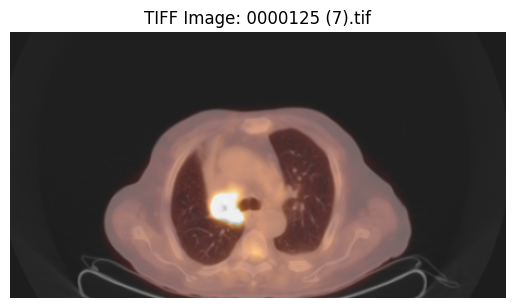

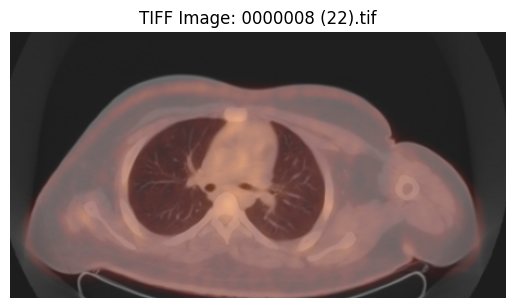

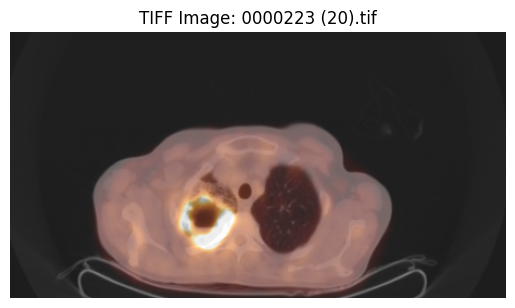

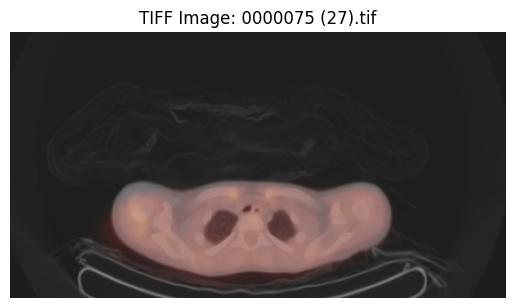

In [6]:
def load_and_plot_random_tiff(directory):
    tiff_files = [filename for filename in os.listdir(directory) if filename.endswith(".tif")]

    if tiff_files:
        random_filename = random.choice(tiff_files)
        image_path = os.path.join(directory, random_filename)
        img = Image.open(image_path)
        img_array = np.array(img)

        plt.imshow(img_array)
        plt.title(f"TIFF Image: {random_filename}")
        plt.axis('off')
        plt.show()

load_and_plot_random_tiff(train_lungCancer_dir)
load_and_plot_random_tiff(train_normal_dir)
load_and_plot_random_tiff(test_lungCancer_dir)
load_and_plot_random_tiff(test_normal_dir)


#**Data generation**

In [7]:
BATCH_SIZE= 80
image_height, image_width = 245, 457

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range= 15,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.1,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        training_set_dir,
        target_size=(image_height, image_width),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle = True)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
        test_set_dir,
        target_size=(image_height, image_width),
        batch_size=10,
        class_mode='binary')

Found 1445 images belonging to 2 classes.
Found 406 images belonging to 2 classes.


#**Defining model**

In [8]:
pre_trained_model = ResNet101V2(include_top=False,
                                        weights= 'imagenet',
                                        input_shape = (image_height, image_width, 3))

for layer in pre_trained_model.layers:
    layer.trainable = False

171317808/171317808 [==============================] - 5s 0us/step


In [9]:
pre_trained_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 245, 457, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 251, 463, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 123, 229, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [10]:
last_layer = pre_trained_model.get_layer('post_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(1)(x)
x = layers.Activation(tf.nn.sigmoid)(x)

model = Model(pre_trained_model.input, x)

last layer output shape:  (None, 8, 15, 2048)


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 245, 457, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 251, 463, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 123, 229, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
savingPath = os.makedirs('/content/sample_data/temporaryWeights')
checkpoint_path = '/content/sample_data/temporaryWeights'
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, verbose= 1)

/content/sample_data/temporaryWeights


In [13]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.7, staircase=True)

In [14]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= lr_schedule), loss= 'binary_crossentropy', 
              metrics= [tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                        tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.Recall(name='Recall'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.AUC(name='AUC')])

In [15]:
history = model.fit(
            train_generator,
            validation_data = test_generator,
            epochs = 40,
            verbose = 1,
            callbacks = [cp_callback])

Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 0.6338 - Binary_accuracy: 0.6630 - Precision: 0.7965 - Recall: 0.4421 - TP: 321.0000 - TN: 637.0000 - FN: 405.0000 - FP: 82.0000 - AUC: 0.7442 
Epoch 1: val_loss improved from inf to 0.52142, saving model to /content/sample_data/temporaryWeights
19/19 [==============================] - 448s 23s/step - loss: 0.6338 - Binary_accuracy: 0.6630 - Precision: 0.7965 - Recall: 0.4421 - TP: 321.0000 - TN: 637.0000 - FN: 405.0000 - FP: 82.0000 - AUC: 0.7442 - val_loss: 0.5214 - val_Binary_accuracy: 0.7586 - val_Precision: 0.6811 - val_Recall: 0.9903 - val_TP: 205.0000 - val_TN: 103.0000 - val_FN: 2.0000 - val_FP: 96.0000 - val_AUC: 0.8870
Epoch 2/40
19/19 [==============================] - ETA: 0s - loss: 0.3873 - Binary_accuracy: 0.8616 - Precision: 0.8507 - Recall: 0.8788 - TP: 638.0000 - TN: 607.0000 - FN: 88.0000 - FP: 112.0000 - AUC: 0.9284
Epoch 2: val_loss improved from 0.52142 to 0.42914, saving model to /content/sample_

##**Downloading history**

In [16]:
def download_history():
    with open('history_augmented_ResNet101V2WholeModel.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    files.download('history_augmented_ResNet101V2WholeModel.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Plotting Loss and Accuracy**

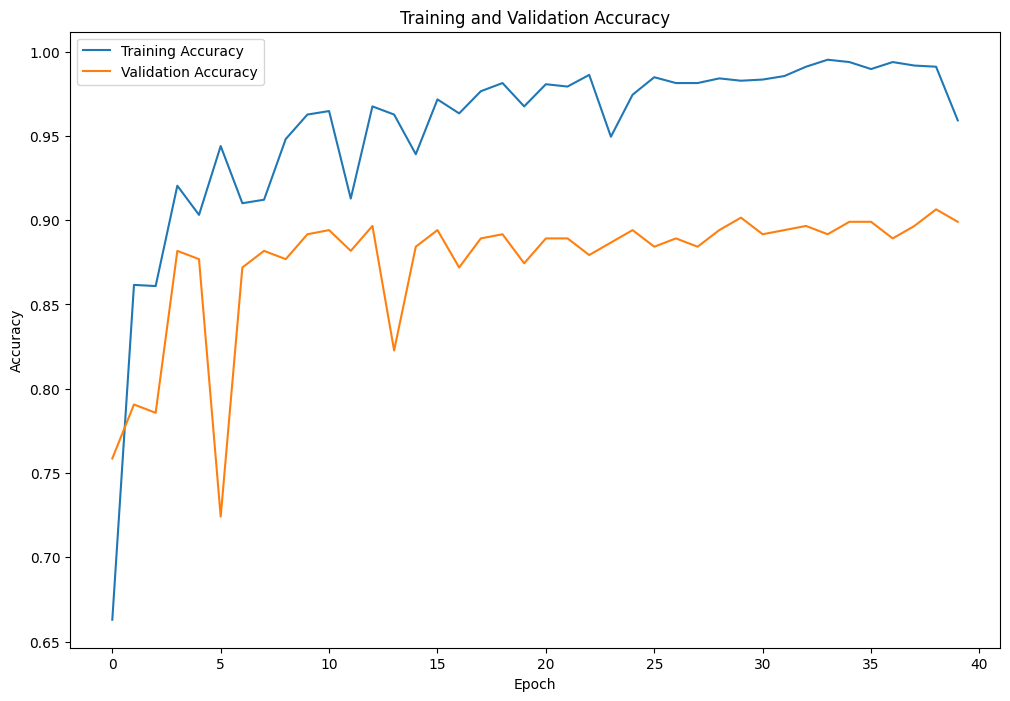

In [17]:
plt.figure(figsize=(12,8))
plt.plot(history.history['Binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_Binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

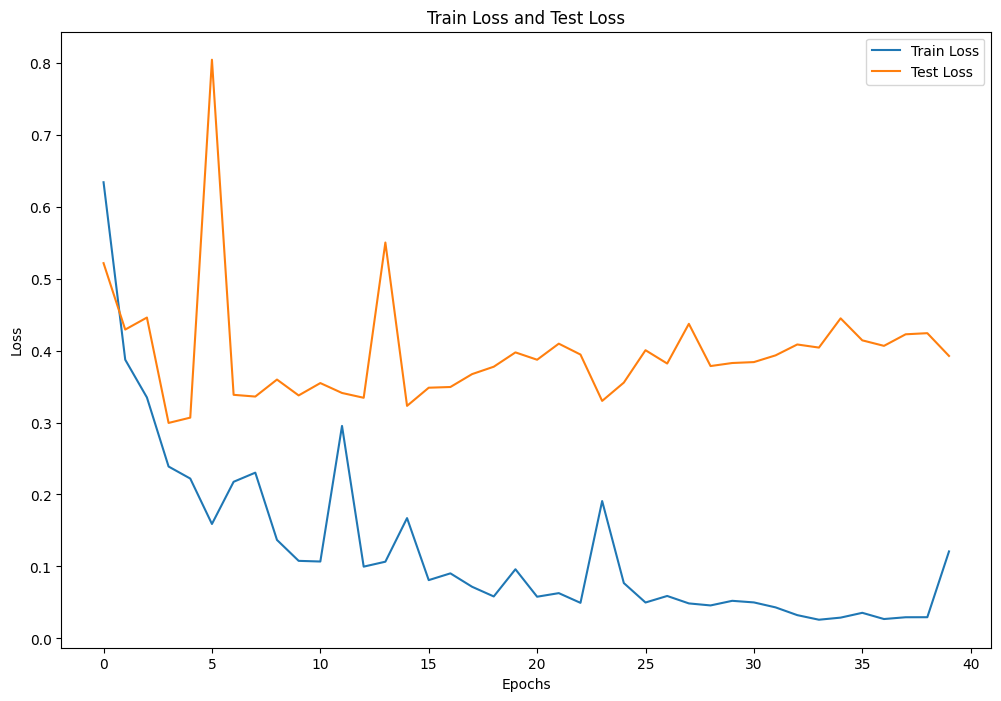

In [18]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss and Test Loss')
plt.show()

##**LoadingWeightsofTheResNet101V2Model**

In [19]:
model2 = Model(pre_trained_model.input, x)

In [20]:
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= lr_schedule), loss= 'binary_crossentropy', 
               metrics= [tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                        tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.Recall(name='Recall'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.AUC(name='AUC')])

In [21]:
model2.load_weights(checkpoint_path)

In [22]:
model2.evaluate(test_generator)

41/41 [==============================] - 9s 153ms/step - loss: 0.2994 - Binary_accuracy: 0.8818 - Precision: 0.8732 - Recall: 0.8986 - TP: 186.0000 - TN: 172.0000 - FN: 21.0000 - FP: 27.0000 - AUC: 0.9365


[0.2994207441806793,
 0.8817734122276306,
 0.8732394576072693,
 0.8985507488250732,
 186.0,
 172.0,
 21.0,
 27.0,
 0.9364820122718811]

##**Predicting test images**

In [23]:
base_dir = '/content/drive/MyDrive/TIFF PET-CTWholeDataset'

training_set_dir = os.path.join(base_dir, 'trainingSet')
test_set_dir = os.path.join(base_dir, 'testSet')

train_lungCancer_dir = os.path.join(training_set_dir, 'lungCancer')
train_normal_dir = os.path.join(training_set_dir, 'normal')
test_lungCancer_dir = os.path.join(test_set_dir, 'lungCancer')
test_normal_dir = os.path.join(test_set_dir, 'normal')

print(test_normal_dir)
print(test_lungCancer_dir)

/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/normal
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/lungCancer


In [25]:
%%time
fileNames1 = os.listdir(test_normal_dir)
filePaths1 = []

for i in fileNames1:
    path = '/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/normal/'
    new_path = path + i
    filePaths1.append(new_path)

my_y_pred1 = []


for fn in filePaths1:
    img = tf.keras.utils.load_img(fn, target_size=(245, 457))
    x = tf.keras.utils.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model2.predict(images, batch_size=10)
    my_y_pred1.append(classes)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " lunCancer does not exist in this slice")
    else:
        print(fn + " lungCancer exists in this slice")


y_pred1 = np.array(my_y_pred1)
y_pred1.resize(1,len(my_y_pred1))
y_pred1

1/1 [==============================] - 3s 3s/step
[0.91416115]
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/normal/0000058 (11).tif lunCancer does not exist in this slice
1/1 [==============================] - 0s 36ms/step
[0.9305043]
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/normal/0000058 (16).tif lunCancer does not exist in this slice
1/1 [==============================] - 0s 33ms/step
[0.8750435]
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/normal/0000058 (12).tif lunCancer does not exist in this slice
1/1 [==============================] - 0s 31ms/step
[0.5037555]
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/normal/0000058 (20).tif lunCancer does not exist in this slice
1/1 [==============================] - 0s 34ms/step
[0.8855818]
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/normal/0000058 (3).tif lunCancer does not exist in this slice
1/1 [==============================] - 0s 33ms/step
[0.937454]
/content/drive/MyDrive/TIFF P

array([[0.91416115, 0.9305043 , 0.8750435 , 0.5037555 , 0.8855818 ,
        0.937454  , 0.829242  , 0.94987065, 0.8704076 , 0.33430204,
        0.40790087, 0.22078244, 0.8071168 , 0.5904657 , 0.9537436 ,
        0.94029945, 0.95468944, 0.7466115 , 0.7085149 , 0.37423623,
        0.92789966, 0.6040459 , 0.8030417 , 0.8440339 , 0.82568043,
        0.932153  , 0.76425546, 0.9226548 , 0.7909929 , 0.20211528,
        0.535033  , 0.62128174, 0.39336294, 0.74670184, 0.89478153,
        0.6919415 , 0.9215234 , 0.94139564, 0.9434504 , 0.9246266 ,
        0.8726808 , 0.9542491 , 0.70721066, 0.98089623, 0.9532183 ,
        0.9729549 , 0.9827511 , 0.77049726, 0.8975079 , 0.93385226,
        0.9553143 , 0.9750704 , 0.9573086 , 0.95146346, 0.9100428 ,
        0.9652494 , 0.93759656, 0.9581159 , 0.95585704, 0.97815907,
        0.95751315, 0.9210264 , 0.9409662 , 0.97036684, 0.91286516,
        0.8976758 , 0.95553094, 0.8695228 , 0.912118  , 0.92449695,
        0.96795624, 0.9329857 , 0.9663274 , 0.95

In [26]:
fileNames2 = os.listdir(test_lungCancer_dir)
filePaths2 = []

for i in fileNames2:
    path = '/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/lungCancer/'
    new_path = path + i
    filePaths2.append(new_path)


my_y_pred2 = []


for fn in filePaths2:
    img = tf.keras.utils.load_img(fn, target_size=(245, 457))
    x = tf.keras.utils.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model2.predict(images, batch_size=10)
    my_y_pred2.append(classes)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " lunCancer does not exist in this slice")
    else:
        print(fn + " lungCancer exists in this slice")


y_pred2 = np.array(my_y_pred2)
y_pred2.resize(1,len(my_y_pred2))
y_pred2

1/1 [==============================] - 0s 27ms/step
[0.00339146]
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/lungCancer/0000156 (10).tif lungCancer exists in this slice
1/1 [==============================] - 0s 53ms/step
[0.03265074]
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/lungCancer/0000156 (1).tif lungCancer exists in this slice
1/1 [==============================] - 0s 27ms/step
[0.00415274]
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/lungCancer/0000156 (11).tif lungCancer exists in this slice
1/1 [==============================] - 0s 30ms/step
[0.00537273]
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/lungCancer/0000156 (13).tif lungCancer exists in this slice
1/1 [==============================] - 0s 133ms/step
[0.00288562]
/content/drive/MyDrive/TIFF PET-CTWholeDataset/testSet/lungCancer/0000156 (12).tif lungCancer exists in this slice
1/1 [==============================] - 0s 86ms/step
[0.00370938]
/content/drive/MyDrive/TIFF PET-CTW

array([[3.39146191e-03, 3.26507390e-02, 4.15274408e-03, 5.37272636e-03,
        2.88561988e-03, 3.70937749e-03, 1.02447858e-02, 3.51719605e-03,
        3.77444690e-03, 5.46556665e-03, 5.45241497e-03, 1.80876919e-03,
        2.63816919e-02, 1.33545194e-02, 7.39584118e-03, 9.45614371e-03,
        8.55903421e-03, 1.07266735e-02, 1.16120633e-02, 2.04409310e-03,
        1.45861898e-02, 2.03449163e-03, 2.15410464e-03, 4.62703593e-03,
        5.32197999e-03, 4.83341282e-03, 1.22265004e-01, 6.99418457e-03,
        1.70355674e-03, 4.84240055e-03, 4.04307060e-03, 4.50996170e-03,
        2.62129158e-02, 4.09213565e-02, 1.04044475e-01, 2.97263592e-01,
        2.28173479e-01, 5.61480634e-02, 6.15215361e-01, 1.28292009e-01,
        3.73024702e-01, 1.68018565e-01, 9.12416875e-02, 1.52428955e-01,
        3.75323631e-02, 5.73896654e-02, 1.20751351e-01, 2.47316770e-02,
        3.57933134e-01, 7.27832764e-02, 7.30956346e-02, 3.83413881e-02,
        9.15764794e-02, 7.72013962e-02, 6.89471439e-02, 9.504698

##**Predicting the uploaded image class**

In [27]:
uploaded=files.upload()

for fn in uploaded.keys():
    path='/content/' + fn
    img = tf.keras.utils.load_img(fn, target_size=(245, 457))
    x = tf.keras.utils.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model2.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " lunCancer does not exist in this slice")
    else:
        print(fn + " lungCancer exists in this slice")

Saving 0000004 (7).tif to 0000004 (7).tif
1/1 [==============================] - 0s 29ms/step
[0.8562457]
0000004 (7).tif lunCancer does not exist in this slice


##**Patient labeling**

In [ ]:
fileNames3 = os.listdir('/content/drive/MyDrive/patient1/lungCancer')
filePaths3 = []

for i in fileNames3:
    path = '/content/drive/MyDrive/patient1/lungCancer/'
    new_path = path + i
    filePaths3.append(new_path)

my_y_pred3 = []
patient_labels = []

for fn in filePaths3:
    img = tf.keras.utils.load_img(fn, target_size=(245, 457))
    x = tf.keras.utils.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model2.predict(images, batch_size=10)
    my_y_pred3.append(classes)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " lunCancer does not exist in this slice")
        patient_labels.append("normal")
    else:
        print(fn + " lungCancer exists in this slice")
        patient_labels.append("lungCancer")

print(patient_labels)


label = patient_labels.count("lungCancer")
if label > 0:
    print("\033[1m"+"Unfortunately the patient is labeled as cancerous!"+"\033[0m")
else:
    print("\033[1m"+"Fortunately the patient is labeled as normal!"+"\033[0m")

1/1 [==============================] - 0s 29ms/step
[0.01664967]
/content/sample_data/patient3/0000105 (20).tif lungCancer exists in this slice
1/1 [==============================] - 0s 29ms/step
[0.01361861]
/content/sample_data/patient3/0000105 (19).tif lungCancer exists in this slice
1/1 [==============================] - 0s 27ms/step
[0.74760306]
/content/sample_data/patient3/0000115 (3).tif lunCancer does not exist in this slice
1/1 [==============================] - 0s 30ms/step
[0.48788008]
/content/sample_data/patient3/0000115 (2).tif lungCancer exists in this slice
1/1 [==============================] - 0s 26ms/step
[0.04179404]
/content/sample_data/patient3/0000105 (23).tif lungCancer exists in this slice
['lungCancer', 'lungCancer', 'normal', 'lungCancer', 'lungCancer']
Unfortunately the patient is labeled as cancerous!


##**ROC curve**

In [28]:
y_pred_ResNet101V2_wholeModel = np.concatenate((y_pred1, y_pred2), axis=None)
print(len(y_pred_ResNet101V2_wholeModel))
label1 = np.ones(len(os.listdir(test_normal_dir)))
label0 = np.zeros(len(os.listdir(test_lungCancer_dir)))
labels = np.concatenate((label1, label0))
print(len(labels))

406
406


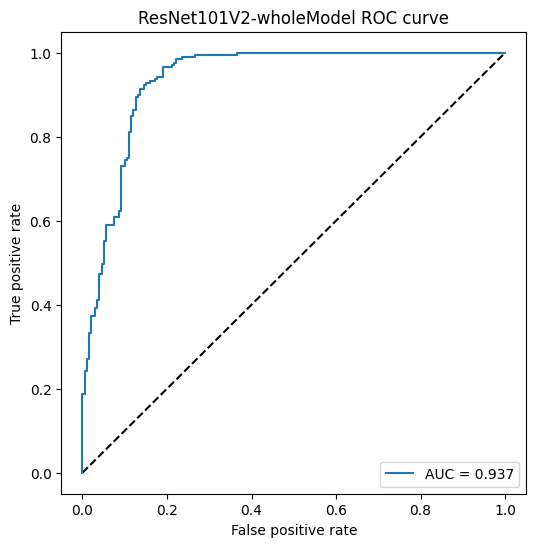

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(labels, y_pred_ResNet101V2_wholeModel, pos_label=1)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ResNet101V2-wholeModel ROC curve')
plt.legend(loc='lower right')
plt.show()

##**Confusion Matrix**

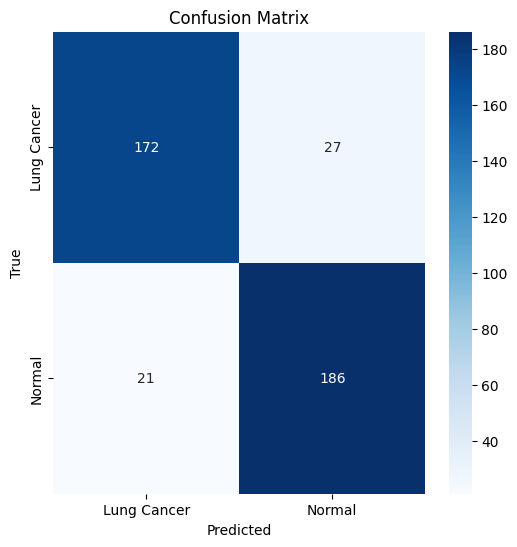

In [33]:
y_pred_classes = (y_pred_ResNet101V2_wholeModel > 0.5).astype(int)

conf_matrix = confusion_matrix(labels, y_pred_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Lung Cancer", "Normal"],
            yticklabels=["Lung Cancer", "Normal"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
model2.evaluate(test_generator)

41/41 [==============================] - 5s 124ms/step - loss: 0.2994 - Binary_accuracy: 0.8818 - Precision: 0.8732 - Recall: 0.8986 - TP: 186.0000 - TN: 172.0000 - FN: 21.0000 - FP: 27.0000 - AUC: 0.9365


[0.29942065477371216,
 0.8817734122276306,
 0.8732394576072693,
 0.8985507488250732,
 186.0,
 172.0,
 21.0,
 27.0,
 0.9364820122718811]